In [2]:
import random, requests, hashlib, base64, time
import json
import re
#from HTMLParser import HTMLParser
from bs4 import BeautifulSoup, NavigableString, Tag
from bs4 import BeautifulSoup as BS
from bs4 import Comment
import csv
import sys
import unicodedata
import datetime
#import arrow
import urllib
import pandas as pd
import numpy as np
import urllib
import urllib.request
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib as mpl


In [3]:
reader = pd.read_csv("datasets/companies_sorted.csv",low_memory=True, chunksize=10**4)
df = pd.concat([x for x in reader], ignore_index=True)
df['size range'] = pd.Categorical(df['size range'], ["1 - 10", "11 - 50", "51 - 200", "201 - 500", "501 - 1000", "1001 - 5000", "5001 - 10000", "10001+"])
print('complete')

complete


In [34]:
df.sort_values(by='current employee estimate', ascending=False).head()

,Unnamed: 0,name,domain,year founded,industry,size range,locality,country,linkedin url,current employee estimate,total employee estimate
0,5872184,ibm,ibm.com,1911.0,information technology and services,10001+,"new york, new york, united states",united states,linkedin.com/company/ibm,274047,716906
1,4425416,tata consultancy services,tcs.com,1968.0,information technology and services,10001+,"bombay, maharashtra, india",india,linkedin.com/company/tata-consultancy-services,190771,341369
2,21074,accenture,accenture.com,1989.0,information technology and services,10001+,"dublin, dublin, ireland",ireland,linkedin.com/company/accenture,190689,455768
3,2309813,us army,goarmy.com,1800.0,military,10001+,"alexandria, virginia, united states",united states,linkedin.com/company/us-army,162163,445958
4,1558607,ey,ey.com,1989.0,accounting,10001+,"london, greater london, united kingdom",united kingdom,linkedin.com/company/ernstandyoung,158363,428960


In [39]:
#value counts
print(df['size range'].value_counts(normalize=True))
print()
print(df['country'].value_counts(normalize=True))
print()
print(df['industry'].value_counts(normalize=True))
#print()
#print(df['year founded'].value_counts(bins=10))
#print()
#print(df['current employee estimate'].value_counts(bins=10))

1 - 10          0.778624
11 - 50         0.157053
51 - 200        0.045286
201 - 500       0.010942
501 - 1000      0.003958
1001 - 5000     0.003421
5001 - 10000    0.000424
10001+          0.000292
Name: size range, dtype: float64

united states                4.723803e-01
united kingdom               1.061247e-01
canada                       3.868419e-02
india                        2.994143e-02
spain                        2.983716e-02
                                 ...     
saint pierre and miquelon    2.072874e-07
niue                         2.072874e-07
saint barthélemy             2.072874e-07
saint helena                 2.072874e-07
norfolk island               2.072874e-07
Name: country, Length: 236, dtype: float64

information technology and services    0.065817
marketing and advertising              0.049127
construction                           0.037470
management consulting                  0.028264
real estate                            0.028109
                    

In [3]:
df['is_ss'] = np.nan
#df.at[4831970, 'is_ss'] = 1
df[df['name'].str.contains('fotio', na=False, regex=False)]

,Unnamed: 0,name,domain,year founded,industry,size range,locality,country,linkedin url,current employee estimate,total employee estimate,is_ss
1386515,4131309,fotiou frames limited,fotiou.com,NaN,consumer goods,1 - 10,"vaughan, ontario, canada",canada,linkedin.com/company/fotiou-frames-limited,5,7,NaN
4831970,689172,fotio,fotio.co,2012.0,photography,1 - 10,NaN,NaN,linkedin.com/company/fotio,1,1,NaN
4899621,39906,f.g.fotiou developments & constructions ltd,fgfotiou.com,1980.0,construction,1 - 10,"mesa geitonia, limassol, cyprus",cyprus,linkedin.com/company/f-g-fotiou-developments-&...,1,3,NaN


In [4]:
for row in df[df.index <= 5].itertuples():
    print(row.Index, row.domain)

0 ibm.com
1 tcs.com
2 accenture.com
3 goarmy.com
4 ey.com
5 hpe.com


In [ ]:
#print(df[df.index < 10
dfa = df
dfa = df[df['name'] == 'fotio']
df = df.sort_values(by='current employee estimate', ascending=True).reset_index(drop=True)
#print(df)
adjustment = 1000 + 5000
counter = adjustment
for row in df[(df.index >= counter) & (df.index < counter + 10) ].itertuples():
    if row.domain == 'nan':
        continue
    else:
        try:
            url2 ='https://' + str(row.domain)
            url = urllib.request.urlopen(url2)
            s = url.read()
            soup = BeautifulSoup(s, 'html.parser')
            comments = soup.find_all(string=lambda text: isinstance(text, Comment))
            #print('start')
            for c in comments:
                if "Squarespace" in c:
                    print(str(i.name) + ": YESS")
                    df.at[row.Index, 'is_ss'] = 1
                    break
            #print(url2)                
            #print('finish')    


        except:
            try:
                url2 ='http://' + str(row.domain)
                #print(url2)
                url = urllib.request.urlopen(url2)
                s = url.read()
                soup = BeautifulSoup(s, 'html.parser')
                comments = soup.find_all(string=lambda text: isinstance(text, Comment))
                for c in comments:
                    if "Squarespace" in c:
                        print(str(i.name) + ": YESS")
                        df.at[row.Index, 'is_ss'] = 1
                        break
            except:
                pass
        
    counter += 1
    if counter == 1 + adjustment:
        print(counter)
    elif counter == 10 + adjustment:
        print(counter)
    elif counter == 100 + adjustment:
        print(counter)
    elif counter == 500 + adjustment:
        print(counter)
    elif counter == 1000 + adjustment:
        print(counter)
    elif counter % 10000 == 0:
        print(counter)
    elif counter % 100000 == 0:
        print(counter)
        
     

6001
6010
6100


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


6500
7000


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
C:\Users\cccnyc1dbl\AppData\Local\Continuum\anaconda32\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


In [ ]:
df[(df['is_ss'] == 1) | (df['name'] == 'fotio')]

In [ ]:
url2= 'https://www.fotio.co/'
with urllib.request.urlopen(url2) as url:
    s = url.read()
    #data = json.loads(url.read())
    #pr = requests.get(url2)
    #data = json.loads(s)
    #print(s)
    soup = BeautifulSoup(s, 'html.parser')
    comments = soup.find_all(string=lambda text: isinstance(text, Comment))
    for c in comments:
        print(c)
        print("===========")
        c.extract()
        if "Squarespace" in c:
            #element = soup.find("script", data-name="static-context")
            #print(element.attrs["Static.SQUARESPACE_CONTEXT"])
            break
        

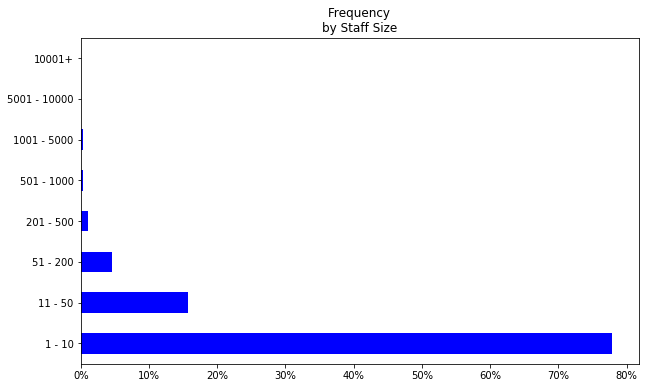

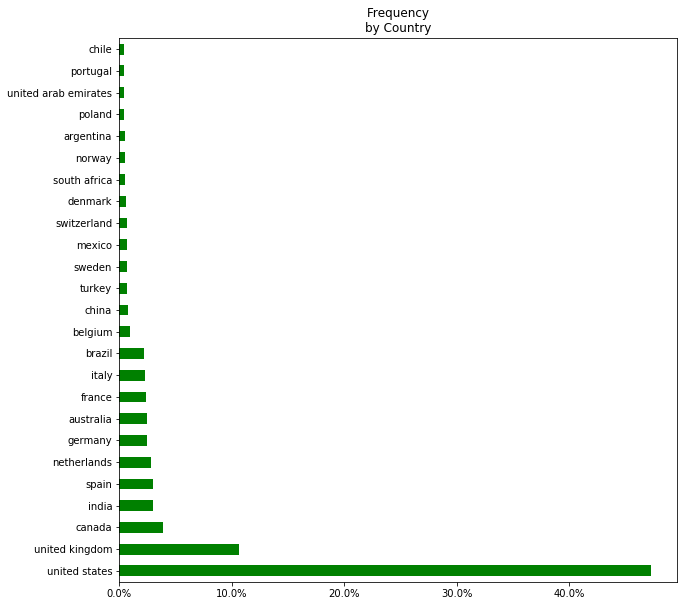

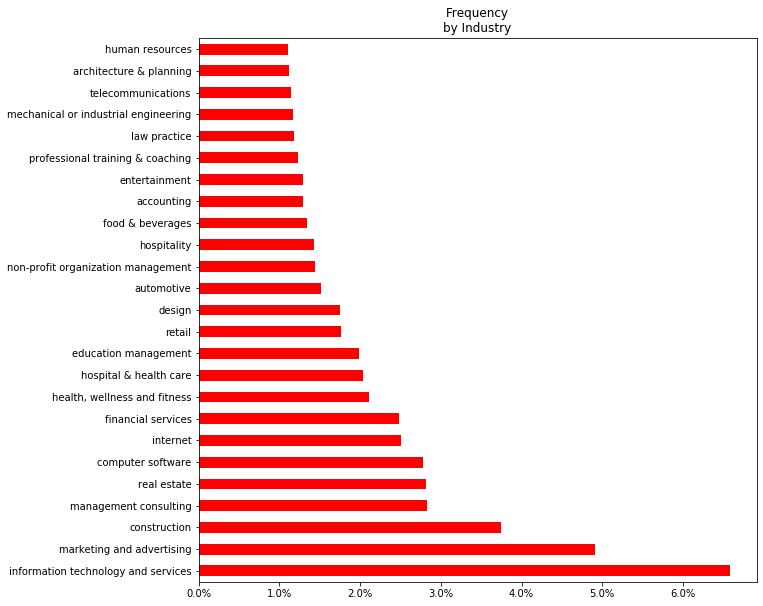

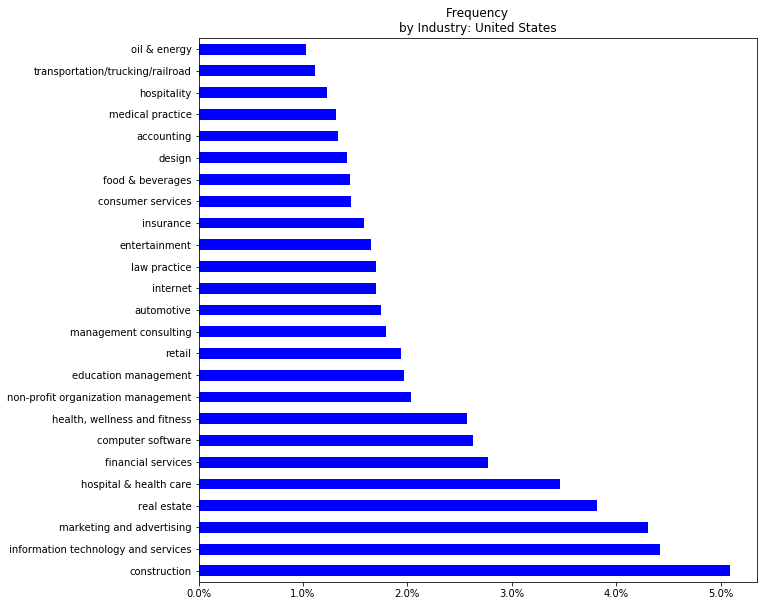

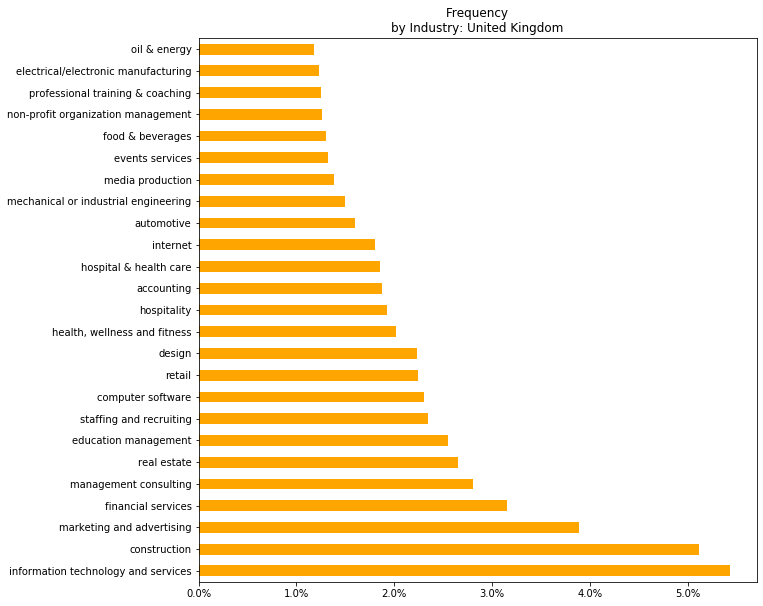

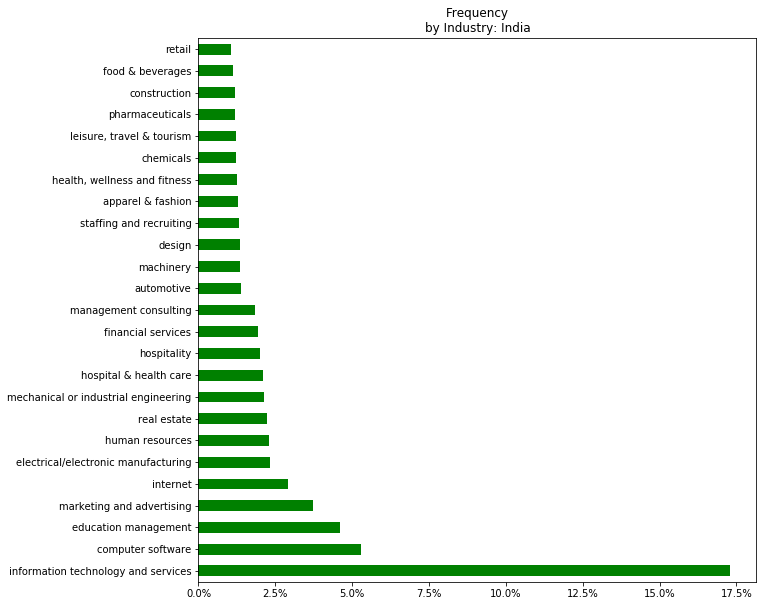

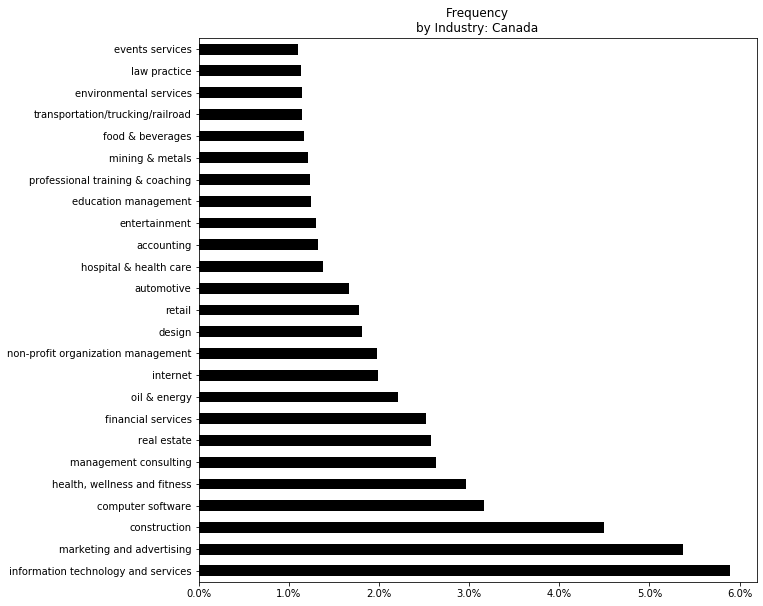

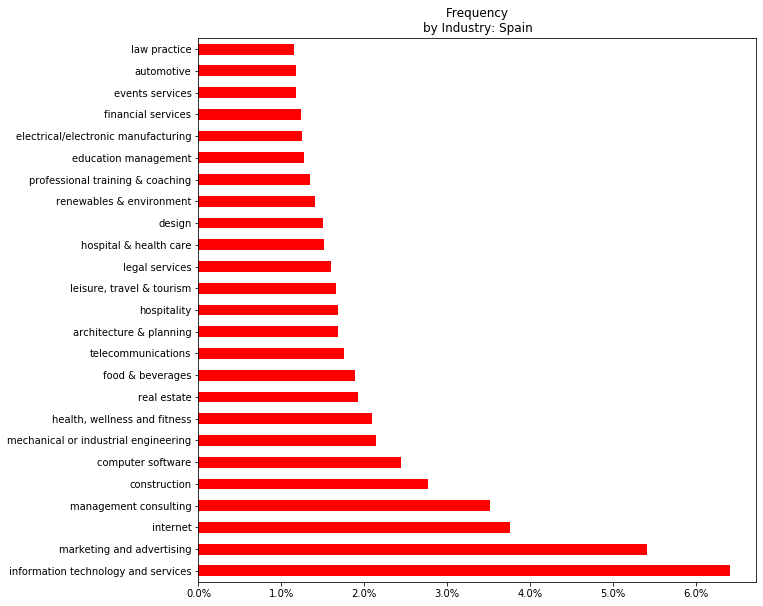

In [36]:
def barchart(data, type, title, limit, figsize, color, normalize=False):
    fig, ax = plt.subplots()
    if type == 'vertical':
        ax = data.value_counts(dropna=True, normalize=normalize).head(limit).plot(ax=ax, kind='bar', title = title, figsize = figsize, color=color)
        if normalize == True:
            ax = ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
        else:
            ax = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    elif type == "horizontal":
        ax = data.value_counts(dropna=True, normalize=normalize).head(limit).plot(ax=ax, kind='barh', title = title, figsize = figsize, color=color)
        if normalize == True:
            ax = ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
        else:
            ax = ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    return ax

barchart(df['size range'], 'horizontal', "Frequency\nby Staff Size", 20, [10,6], 'blue', True)
barchart(df['country'], 'horizontal', "Frequency\nby Country", 25, [10,10], 'green', True)
barchart(df['industry'], 'horizontal', "Frequency\nby Industry", 25, [10,10], 'red', True)
print()
barchart(df[df['country'] == 'united states']['industry'], 'horizontal', "Frequency\nby Industry: United States", 25, [10,10], 'blue', True)
barchart(df[df['country'] == 'united kingdom']['industry'], 'horizontal', "Frequency\nby Industry: United Kingdom", 25, [10,10], 'orange', True)
barchart(df[df['country'] == 'india']['industry'], 'horizontal', "Frequency\nby Industry: India", 25, [10,10], 'green', True)
barchart(df[df['country'] == 'canada']['industry'], 'horizontal', "Frequency\nby Industry: Canada", 25, [10,10], 'black', True)
barchart(df[df['country'] == 'spain']['industry'], 'horizontal', "Frequency\nby Industry: Spain", 25, [10,10], 'red', True)


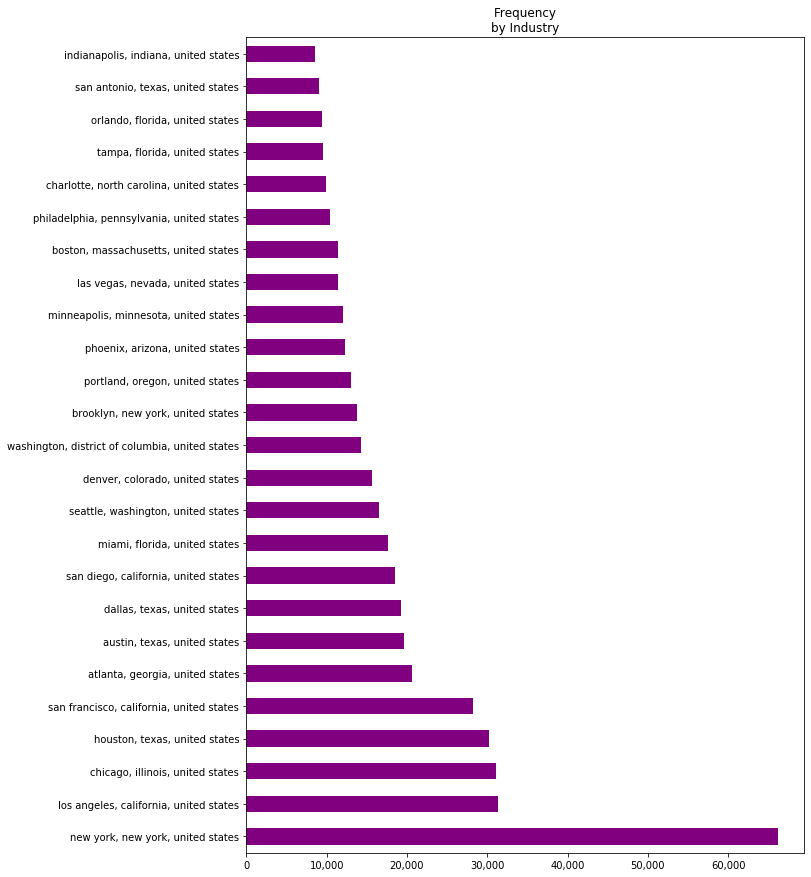

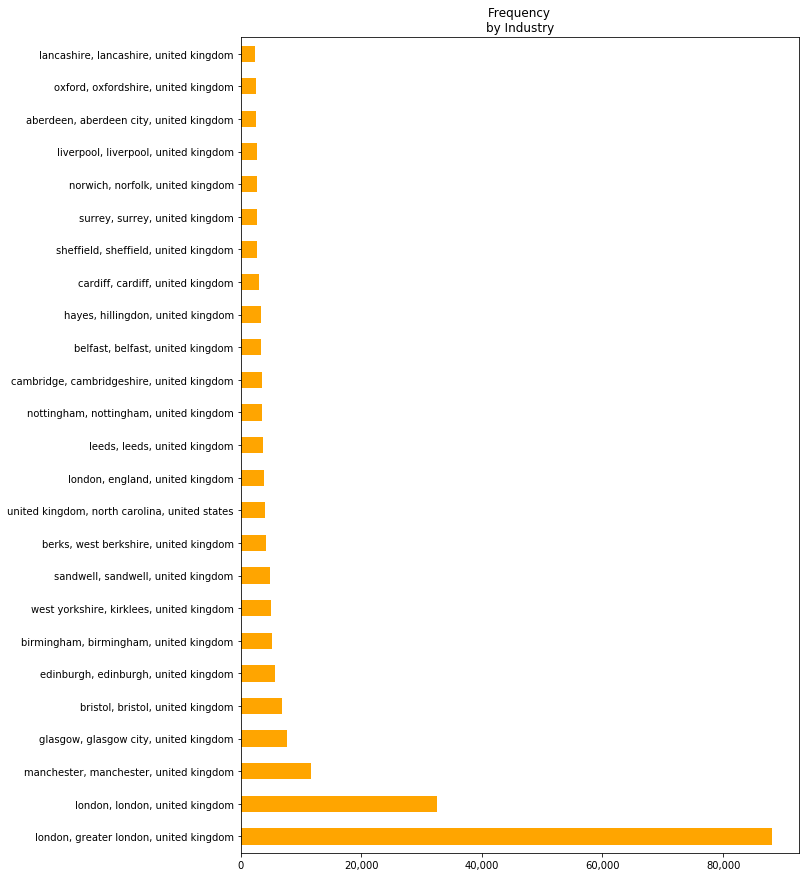

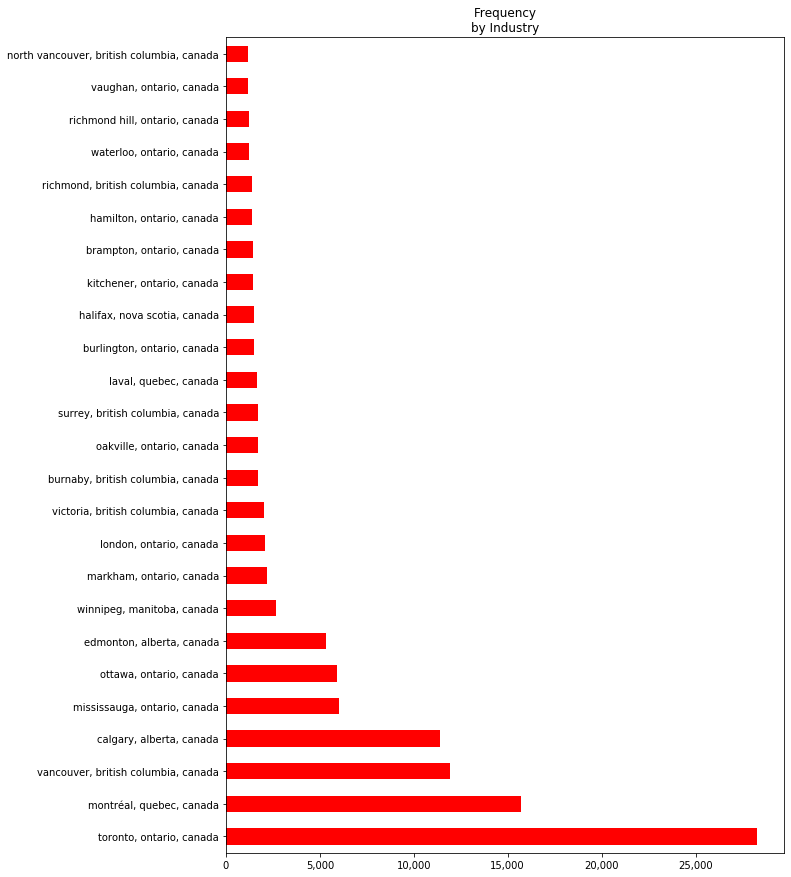

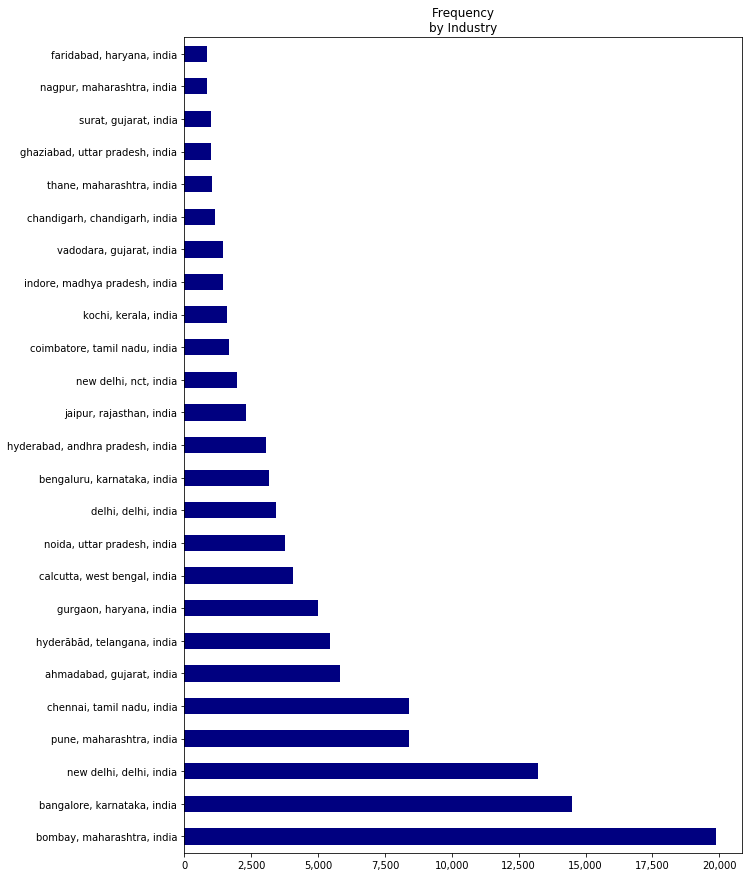

In [77]:
barchart(df[df['country'] == 'united states']['locality'], 'horizontal', "Frequency\nby Industry", 25, [10,15], 'purple')
barchart(df[df['country'] == 'united kingdom']['locality'], 'horizontal', "Frequency\nby Industry", 25, [10,15], 'orange')
barchart(df[df['country'] == 'canada']['locality'], 'horizontal', "Frequency\nby Industry", 25, [10,15], 'red')
barchart(df[df['country'] == 'india']['locality'], 'horizontal', "Frequency\nby Industry", 25, [10,15], 'navy')

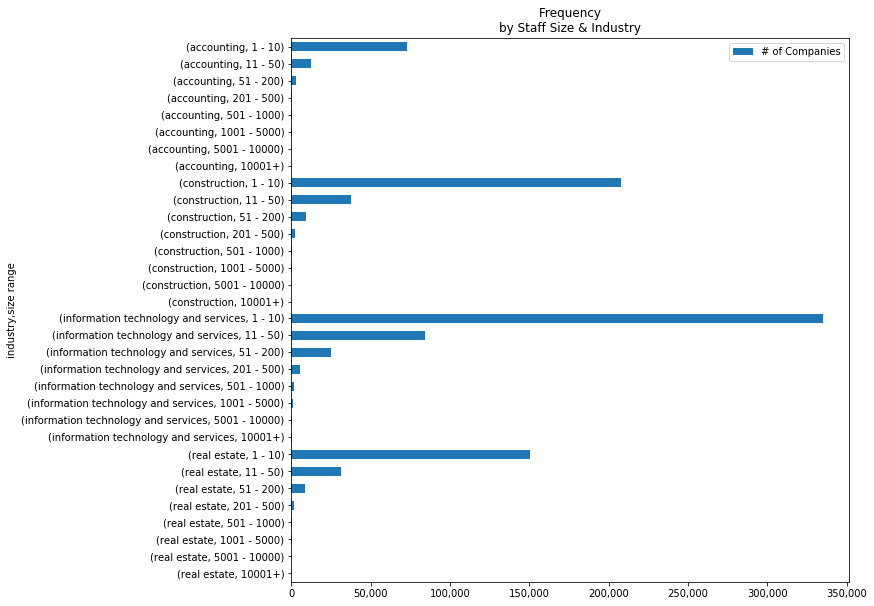

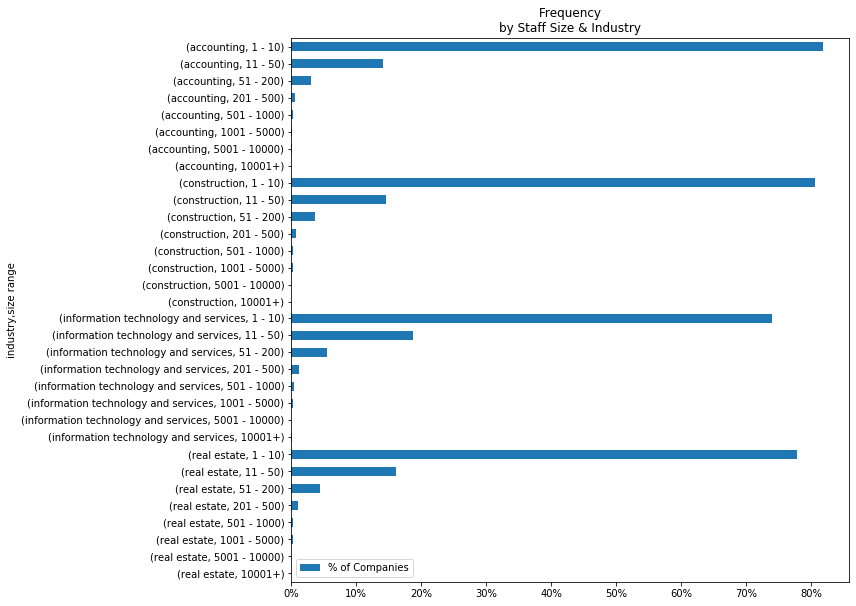

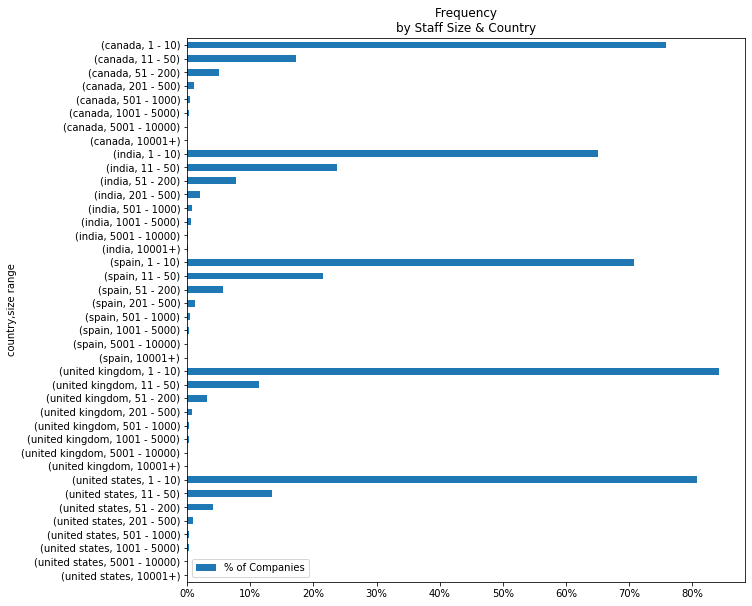

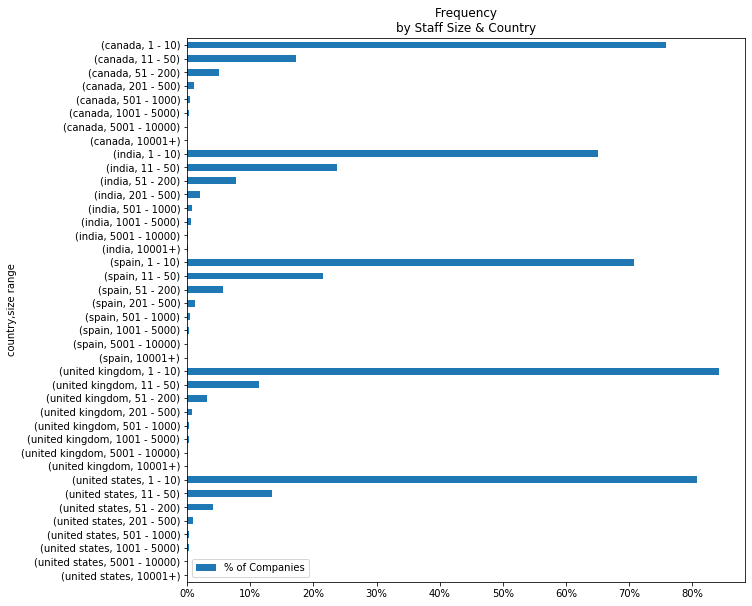

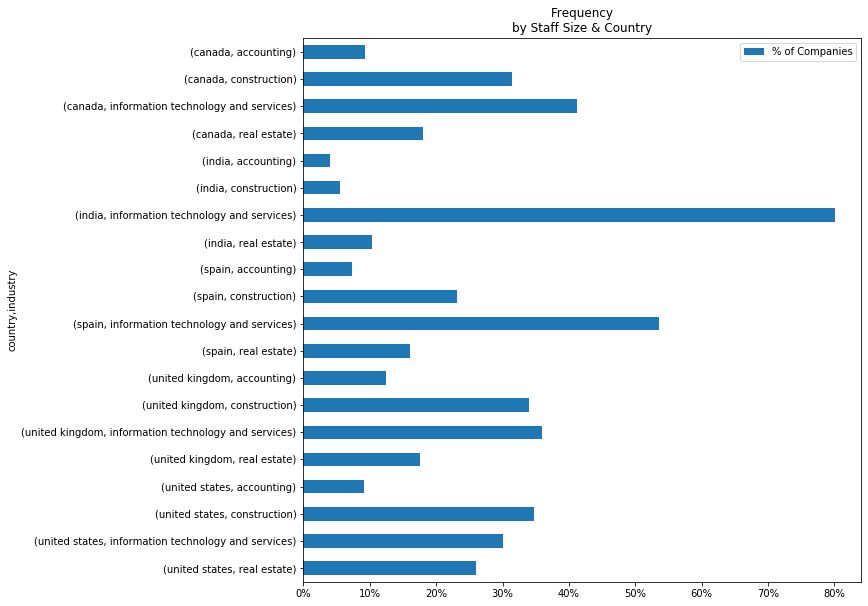

In [27]:

def doublebarchart(df, columns, filtera, filterb, type, title, limit, figsize, color, normalize=False):
    
    if type == 'vertical':
        if normalize == False:
            fig, ax = plt.subplots()
            if filterb is None:
                ax = df[df[columns[0]].isin(filtera)].groupby(columns).size().to_frame('# of Companies').sort_index(level=columns, ascending = [False, False]).head(limit).plot(ax=ax, kind='bar', title = title, figsize = figsize)
            else:
                ax = df[(df[columns[0]].isin(filtera)) & (df[columns[1]].isin(filterb))].groupby(columns).size().to_frame('# of Companies').sort_index(level=columns, ascending = [False, False]).head(limit).plot(ax=ax, kind='bar', title = title, figsize = figsize)
            
            ax = ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        else:
            if filterb is None:
                ax = df[df[columns[0]].isin(filtera)].groupby(columns).size()
            else:
                ax = df[(df[columns[0]].isin(filtera)) & (df[columns[1]].isin(filterb))].groupby(columns).size()
            ax = ax.div(ax.sum(level=0), level=0).to_frame('% of Companies').sort_index(level=columns, ascending = [False, False]).head(limit).plot.bar(title = title, figsize = figsize)
            ax = ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
        
    elif type == "horizontal":
        if normalize == False:
            fig, ax = plt.subplots()
            if filterb is None:
                ax = df[df[columns[0]].isin(filtera)].groupby(columns).size().to_frame('# of Companies').sort_index(level=columns, ascending = [False, False]).head(limit).plot(ax=ax, kind='barh', title = title, figsize = figsize)
            else:
                ax = df[(df[columns[0]].isin(filtera)) & (df[columns[1]].isin(filterb))].groupby(columns).size().to_frame('# of Companies').sort_index(level=columns, ascending = [False, False]).head(limit).plot(ax=ax, kind='barh', title = title, figsize = figsize)
             
            ax = ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
            
        else:
            if filterb is None:
                ax = df[df[columns[0]].isin(filtera)].groupby(columns).size()
            else:
                ax = df[(df[columns[0]].isin(filtera)) & (df[columns[1]].isin(filterb))].groupby(columns).size()
            ax = ax.div(ax.sum(level=0), level=0).to_frame('% of Companies').sort_index(level=columns, ascending = [False, False]).head(limit).plot.barh(title = title, figsize = figsize)
            ax = ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
        
        
    return ax

doublebarchart(df, ['industry', 'size range'], ['information technology and services', 'construction', 'information technology and services', 'accounting', 'real estate'], None, 'horizontal', "Frequency\nby Staff Size & Industry", 100, [10,10], 'blue', False)
doublebarchart(df, ['industry', 'size range'], ['information technology and services', 'construction', 'information technology and services', 'accounting', 'real estate'], None, 'horizontal', "Frequency\nby Staff Size & Industry", 100, [10,10], 'blue', True)

print()
doublebarchart(df, ['country', 'size range'], ['united states', 'united kingdom', 'canada', 'india', 'spain'], None, 'horizontal', "Frequency\nby Staff Size & Country", 100, [10,10], 'blue', True)
doublebarchart(df, ['country', 'size range'], ['united states', 'united kingdom', 'canada', 'india', 'spain'], None, 'horizontal', "Frequency\nby Staff Size & Country", 100, [10,10], 'blue', True)
doublebarchart(df, ['country', 'industry'], ['united states', 'united kingdom', 'canada', 'india', 'spain'], ['information technology and services', 'construction', 'information technology and services', 'accounting', 'real estate'], 'horizontal', "Frequency\nby Staff Size & Country", 100, [10,10], 'blue', True)